<p style="font-size:14pt;text-align:center;">
Training Fast R-CNN network on PascalVOC 2005.
</p>

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import numpy.random as npr
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys
from tqdm import tqdm
from itertools import tee

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, NonlinearityLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params, set_all_param_values
import lasagne.layers as layers
import lasagne.objectives as objectives
import lasagne.nonlinearities as nonlinearities
    
import bnr_ml.objectdetect.fastrcnn as fastrcnn
import bnr_ml.utils.helpers as helpers
from bnr_ml.objectdetect.utils import BoundingBox, draw_coord
import bnr_ml.objectdetect.utils as utils

from selectivesearch import selective_search

import simplejson

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.json', 'r') as f:
    annotations = simplejson.load(f)

In [4]:
# def add_proper_labels(annotations):
#     for im in annotations:
#         for obj in im:
#             if 'car' in obj['label'].lower():
#                 obj['label'] = 'car'
#             elif 'bicycle' in obj['label'].lower():
#                 obj['label'] = 'bicycle'
#             elif 'person' in obj['label'].lower():
#                 obj['label'] = 'person'
#             elif 'motorbike' in obj['label'].lower():
#                 obj['label'] = 'bike'
#             elif 'bike' in obj['label'].lower():
#                 obj['label'] = 'bicycle'
#             else:
#                 print obj

In [5]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for a in annotations:
        for obj in a['annotations']:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [6]:
def fix_labels(annotations):
    for a in annotations:
        a['image'] = '/usr/local/python/bnr_ml/data/PascalVOC/' + a['image']
        new_objs = []
        for obj in a['annotations']:
            lab = obj['label'].lower()
            if 'car' in lab:
                lab = 'car'
            elif 'person' in lab:
                lab = 'person'
            elif 'bike' in lab:
                lab = 'bike'
            elif 'bicycle' in lab:
                lab = 'bicycle'
            else:
                lab = None
                
            if lab != None:
                obj['label'] = lab
                new_objs.append(obj)
        a['annotations'] = new_objs
    return annotations

In [7]:
# def fix_obj(obj):
#     x, y = obj['p1'][0], obj['p1'][1]
#     w, h = obj['p2'][0] - x, obj['p2'][1] - y
#     obj['x'], obj['y'], obj['w'], obj['h'] = x, y, w, h
#     del obj['p1'], obj['p2']
#     return get_num_from_label(obj)

In [8]:
# add_proper_dlabels(annotations)

In [9]:
annotations = fix_labels(annotations)

In [10]:
annotations = np.asarray(annotations)

In [11]:
counts = get_label_counts(annotations)

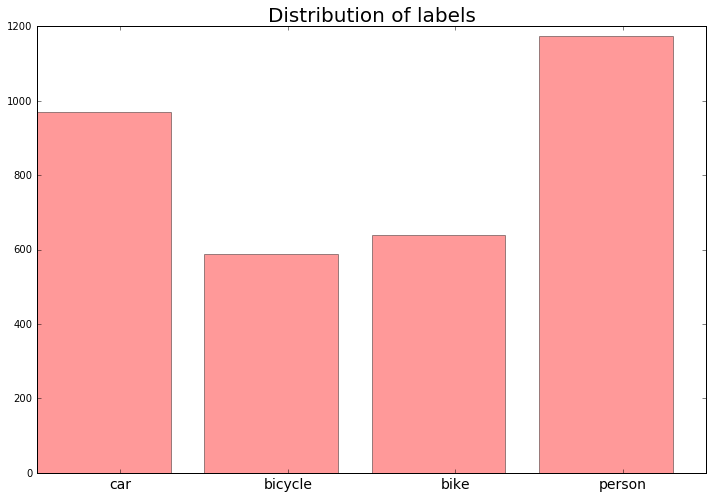

In [12]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [13]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [14]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [15]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

<b>Fix annotations so that you can use the static method for generating data for fast r-cnn.</b>

<b>Now we define the net for recognition.</b>

In [16]:
num_epochs = 1000
batch_size = 50

In [17]:
num_classes = 4

In [18]:
lab2num = {
    'car': 0,
    'bicycle': 1,
    'bike': 2,
    'person': 3,
    'nothing': 4
}

In [19]:
reload(fastrcnn)

<module 'bnr_ml.objectdetect.fastrcnn' from '/usr/local/python/bnr_ml/objectdetect/fastrcnn.pyc'>

In [20]:
input_shape = (160,160)

In [21]:
test_net = False
if test_net:
    gen = test_gen = fastrcnn.generate_rois(
        test_annotations[10:12],
        input_shape,
        num_classes,
        lab2num,
        N=20,
        neg=.5
    )
    X,y = [g for g in gen][0]
    X,y = theano.shared(X), theano.shared(y)
    input_var = X
else:
    input_var = None

In [72]:
net = {}
net['input'] = InputLayer((None, 3) + input_shape, input_var=input_var)
net['conv1_1'] = Conv2DLayer(net['input'], 64, 3, pad=1)
net['conv1_2'] = Conv2DLayer(net['conv1_1'], 64, 3, pad=1)
net['pool1'] = Pool2DLayer(net['conv1_2'], 2)
net['conv2_1'] = Conv2DLayer( net['pool1'], 128, 3, pad=1)
net['conv2_2'] = Conv2DLayer(net['conv2_1'], 128, 3, pad=1)
net['pool2'] = Pool2DLayer(net['conv2_2'], 2)
net['conv3_1'] = Conv2DLayer(net['pool2'], 256, 3, pad=1)
net['conv3_2'] = Conv2DLayer(net['conv3_1'], 256, 3, pad=1)
net['conv3_3'] = Conv2DLayer(net['conv3_2'], 256, 3, pad=1)
net['pool3'] = Pool2DLayer(net['conv3_3'], 2)
net['conv4_1'] = Conv2DLayer(net['pool3'], 512, 3, pad=1)
net['conv4_2'] = Conv2DLayer(net['conv4_1'], 512, 3, pad=1)
net['conv4_3'] = Conv2DLayer(net['conv4_2'], 512, 3, pad=1)
net['pool4'] = Pool2DLayer(net['conv4_3'], 2)
net['conv5_1'] = Conv2DLayer(net['pool4'], 512, 3, pad=1)
net['conv5_2'] = Conv2DLayer(net['conv5_1'], 512, 3, pad=1)
net['conv5_3'] = Conv2DLayer(net['conv5_2'], 512, 3, pad=1)
net['pool5'] = Pool2DLayer(net['conv5_3'], 2)
net['fc6'] = DenseLayer(net['pool5'], num_units=2048)
net['fc6_dropout'] = dropout(net['fc6'], p=0.75)
net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=2048)
net['fc7_dropout'] = dropout(net['fc7'], p=0.5)
# net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
# net['prob'] = NonlinearityLayer(net['fc8'], nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [23]:
load_pretrained = True
if load_pretrained:
    with open('/usr/local/python/bnr_ml/data/pretrained/vgg16.pkl', 'rb') as f:
        weights = pk.load(f)['param values']
        lasagne.layers.set_all_param_values(net['conv5_3'], weights[:-6])

In [73]:
for lname in net:
    layer = net[lname]
    if layer.__class__ == Conv2DLayer:
        layer.W.set_value(layer.W.get_value(borrow=True)[:,:,::-1,::-1])

<b>Add extra layers to network for detection</b>

In [74]:
net['dense2'] = DenseLayer(dropout(net['fc6'], p=.5), 2048, nonlinearity=None)
net['detect'] = DenseLayer(dropout(net['fc7'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)
net['localize'] = DenseLayer(dropout(net['dense2'], p=.5), (num_classes + 1) * 4)

In [76]:
load_weights = True
if load_weights:
    with open('vgg16_fastrcnn_weights.pkl', 'rb') as f:
        params = pk.load(f)
        tmp = params[:-4]
        tmp.extend(params[-2:])
        set_all_param_values(net['detect'], params[:])
        set_all_param_values(net['localize'], tmp)

ValueError: mismatch: got 36 values to set 32 parameters

<b>Train the network

In [27]:
reload(fastrcnn)
reload(utils)

<module 'bnr_ml.objectdetect.utils' from '/usr/local/python/bnr_ml/objectdetect/utils.pyc'>

In [28]:
detector = fastrcnn.FastRCNNDetector(net, num_classes)

/Library/Python/2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


cost = detector._get_cost(detector._detect_test, detector._localize_test, y)

In [29]:
print_obj = helpers.NotebookPrinter(open('/dev/stdout', 'w'), sys.stdout)

In [ ]:
train_loss, test_loss = detector.train(
    train_annotations[:],
    test_annotations[:],
    lab2num,
    print_obj,
    N=10,
    num_batch=2,
    neg=.5,
#     num_batch_test=2,
#     N_test=20,
#     neg_test=.5,
    lr=1e-5,
    lmbda=1., # 0 is pre-training?
    epochs=num_epochs
)

Getting cost...
Compiling...


  0%|          | 0/893 [00:00<?, ?it/s]

Compiling took 27.096 seconds
Beginning training


  0%|          | 1/893 [00:04<1:06:01,  4.44s/it]

Batch error: 2.2752


  0%|          | 2/893 [00:08<1:03:23,  4.27s/it]

Batch error: 2.3334


  0%|          | 3/893 [00:12<1:02:08,  4.19s/it]

Batch error: 2.3664


  0%|          | 4/893 [00:16<1:01:10,  4.13s/it]

Batch error: 2.2371


  1%|          | 5/893 [00:20<1:00:32,  4.09s/it]

Batch error: 2.2252


  1%|          | 6/893 [00:24<1:00:01,  4.06s/it]

Batch error: 1.8769


  1%|          | 7/893 [00:28<59:36,  4.04s/it]  

Batch error: 1.7757


  1%|          | 8/893 [00:32<59:25,  4.03s/it]

Batch error: 2.2489


  1%|          | 9/893 [00:36<59:18,  4.03s/it]

Batch error: 1.9901


  1%|          | 10/893 [00:40<59:04,  4.01s/it]

Batch error: 1.2916


  1%|          | 11/893 [00:44<59:02,  4.02s/it]

Batch error: 2.1025


  1%|▏         | 12/893 [00:48<58:56,  4.01s/it]

Batch error: 2.0180


  1%|▏         | 13/893 [00:52<58:46,  4.01s/it]

Batch error: 1.8142


In [66]:
'''
first 23 iters - 1e-5 lr
next 2 - 3e-6
next 10 - 1e-5, but decreased the p's for dropout .75 -> .5

'''
concat_losses = True
if not concat_losses:
    train_loss_total, test_loss_total = train_loss, test_loss
else:
    train_loss_total = np.concatenate((train_loss_total, train_loss))
    test_loss_total = np.concatenate((test_loss_total, test_loss))

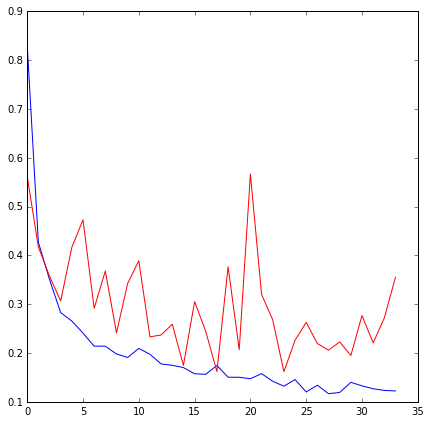

In [77]:
plt.figure(figsize=(7,7))
plt.plot(train_loss_total, 'b')
plt.plot(test_loss_total, 'r')

plt.show()

In [68]:
with open('vgg16_fastrcnn_weights.pkl', 'wb') as f:
    params = [p.get_value() for p in detector.params]
    pk.dump(params, f)

In [35]:
def trans_regions(regions):
    regs = np.zeros((regions.__len__(), 4))
    for i in range(regions.__len__()):
        regs[i] = regions[i]['rect']
    return regs

In [36]:
def num2label(num):
    if num == 0:
        return 'car'
    if num == 1:
        return 'bicycle'
    if num == 2:
        return 'bike'
    if num == 3:
        return 'person'
    else:
        return 'nothing'

In [40]:
im = imread(test_annotations[10]['image'])

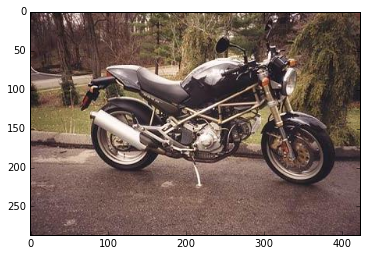

In [41]:
plt.imshow(im);

In [42]:
regions = selective_search(im, scale=500, sigma=0.9, min_size=400)

In [43]:
regions = trans_regions(regions[1])
print regions.shape

(79, 4)


In [78]:
class_score, coord = detector.detect(im, proposals=np.asarray([[0,0,410,270]]), thresh=.8)
print coord.shape
preds = np.concatenate((coord, np.max(class_score, axis=1, keepdims=True), \
                        np.argmax(class_score, axis=1).reshape((-1,1))), axis=1)

(1, 4)


In [59]:
im = resize(im, input_shape)

In [56]:
tmpfn = theano.function([detector.input], detector._localize_test)

In [80]:
tmpfn(im.reshape((1,) + im.shape).swapaxes(3,2).swapaxes(2,1).astype(theano.config.floatX))

array([[[ 0.05355246,  0.        ,  0.5665307 ,  0.53774792],
        [ 0.        ,  0.        ,  0.75756979,  0.67353827],
        [ 0.        ,  0.        ,  0.77599746,  0.67462069],
        [ 0.02985543,  0.05635969,  0.37355611,  0.55610418],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]], dtype=float32)

In [54]:
im_draw = utils.draw_coord(im, preds[:], label_map=num2label)

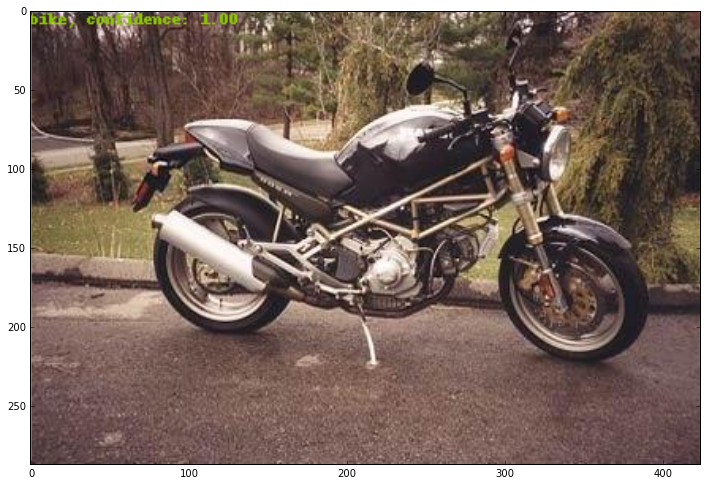

In [55]:
plt.figure(figsize=(12,12))
plt.imshow(im_draw)

In [ ]:
target = T.matrix('target')

In [ ]:
pred_fn = theano.function([detector.input], detector._detect_test)

In [ ]:
acc = T.mean(T.eq(detector._detect_test.argmax(axis=1), target.argmax(axis=1)))
acc_fn = theano.function([detector.input, target], acc)

In [ ]:
acc2_fn = theano.function([detector.input, target], T.eq(detector._detect_test.argmax(axis=1), target.argmax(axis=1)))

In [ ]:
reload(fastrcnn)

In [ ]:
gen = fastrcnn.generate_rois(
    test_annotations[:200],
    input_shape,
    num_classes,
    lab2num,
    num_batch=25,
    N=2,
    neg=.5
)
# tdat = [g for g in gen]

In [ ]:
a = [g for g in gen]

In [ ]:
X,y = a[1]

In [ ]:
N = int(X.shape[0] * np.random.rand())
im, lab = swap(X[N]), y[N]

In [ ]:
plt.imshow(im)
print num2label(lab[-5:].argmax())
print lab[:4]

In [ ]:
accarr = []
# gen = fastrcnn.FastRCNNDetector.generate_data(test_annotations[:200], input_shape, num_classes, num_rios=1, per_batch=50)
for X,y in tqdm(gen):
    acc = acc_fn(X,y[:,-5:])
    print acc
    accarr.append(acc)
print np.mean(accarr)

In [ ]:
swap = lambda im: im.swapaxes(0,1).swapaxes(1,2)

In [ ]:
idx = np.arange(X.shape[0])[np.bitwise_not(acc2_fn(X,y[:,-5:]).astype(np.bool))]

In [ ]:
N = int(X.shape[0] * np.random.rand())

In [ ]:
im, lab, pred = swap(X[N]), num2label(y[N,-5:].argmax()), pred_fn(X[[N]])[0]

In [ ]:
plt.imshow(im)
print('Prediction: %s, Conf: %s, Ground Truth: %s' % (num2label(pred.argmax()), pred.max(), lab))